Let's look at the Decrypto game under the lens of word2vec.

In [2]:
import decryptoai.word2vec_loader.loader as wv_loader

limit = 200_000
print(f"Loading {limit} keys")
google_news_wv = wv_loader.load_word2vec_keyedvectors(limit=limit, debug=True)

Loading 200000 keys


Let's see if the model has each of our official words

In [3]:
import decryptogame as dg

for word in dg.official_words.english.words:
    if word.lower() not in google_news_wv:
        print(word)

SCIENCE-FICTION
FRANCE
CYCLOPS
EGYPT
EXTRA-TERRESTRIAL
CALENDA
GERMANY
QUEBEC
PEGASUS
ARMOUR
CENTAUR
AFRICA
RUSSIA
SLAUGHTER-HOUSE
THEATRE
MOUSTACHE


I suspect this may just be a matter of capitalization, formatting, and British spellings. Let's see if we can make a mapping; if not we can use the weak linearity of Word2Vec. 

In [4]:
def official_keyword_to_word(keyword: str):
    typos = { "CALENDA": "calendar"}
    if keyword in typos:
        return typos[keyword]
    proper_nouns = [
        "AFRICA",
        "AUSTRALIA",
        "CALIFORNIA",
        "CENTAUR",
        "CYCLOPS",
        "EGYPT",
        "FRANCE",
        "GERMANY",
        "OLYMPICS",
        "PEGASUS",
        "QUEBEC",
        "RUSSIA",
        "TEXAS"
    ]
    if keyword in proper_nouns:
        return keyword.capitalize()
    british = {
        "ARMOUR": "armor",
        "MOUSTACHE": "mustache",
        "THEATRE": "theater",
    }
    if keyword in british:
        return british[keyword]
    if '-' in keyword:
        if keyword == "SCIENCE-FICTION":
            keyword = keyword.replace('-', '_')
        keyword = keyword.replace('-', '')
    return keyword.lower()

all_included = True
for keyword in dg.official_words.english.words:
    if official_keyword_to_word(keyword) not in google_news_wv:
        print(keyword)
        all_included = False
if not all_included:
    print("Gonna have to improvise")
print("Done!")

Done!


Looks like we don't need to improvise! Let's see what the keywords the creators chose look like using t-SNE.

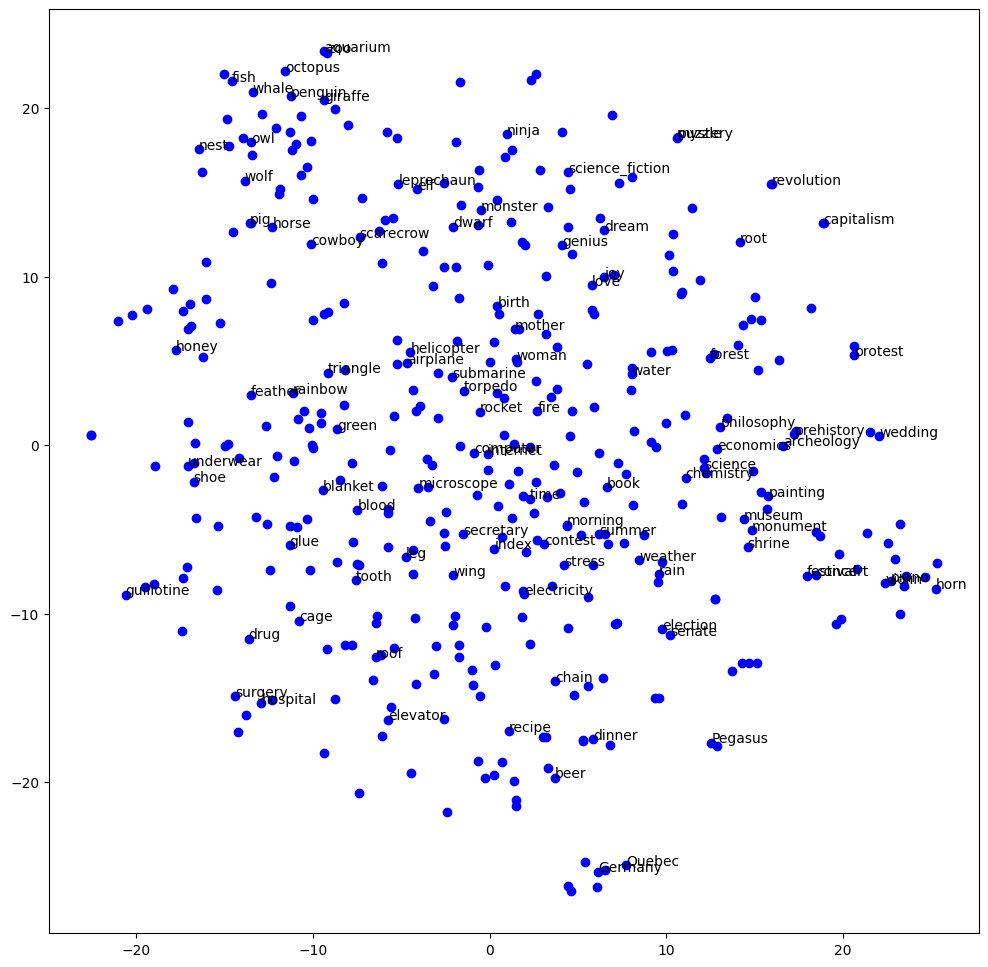

In [5]:
# inspired by https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py

from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling
import matplotlib.pyplot as plt
import random

random.seed(400)

official_words = [official_keyword_to_word(word) for word in dg.official_words.english.words]
official_vectors = np.asarray([google_news_wv[word] for word in official_words])

# reduce using t-SNE
num_dimensions = 2
tsne = TSNE(n_components=num_dimensions, random_state=0)
tsne_official_vectors = tsne.fit_transform(official_vectors)
official_x_vals, official_y_vals, *_ = zip(*tsne_official_vectors) # x has v[0] for each vector, y has v[1]

def plot_with_matplotlib(fig, ax, x_vals, y_vals, labels, num_show=100, color="b"):
    
    ax.scatter(x_vals, y_vals, color=color)

    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, num_show)
    for i in selected_indices:
        ax.annotate(labels[i], (x_vals[i], y_vals[i]))

fig, ax = plt.subplots(figsize=(12, 12))
plot_with_matplotlib(fig, ax, official_x_vals, official_y_vals, official_words)

How do the words compare to words in the general corpus? I predict it will be clustered because although they may have tried to choose dissimilar words, the words are almost all nouns and share a similar type; furthermore, the creators also probably didn't choose extremely rare words.

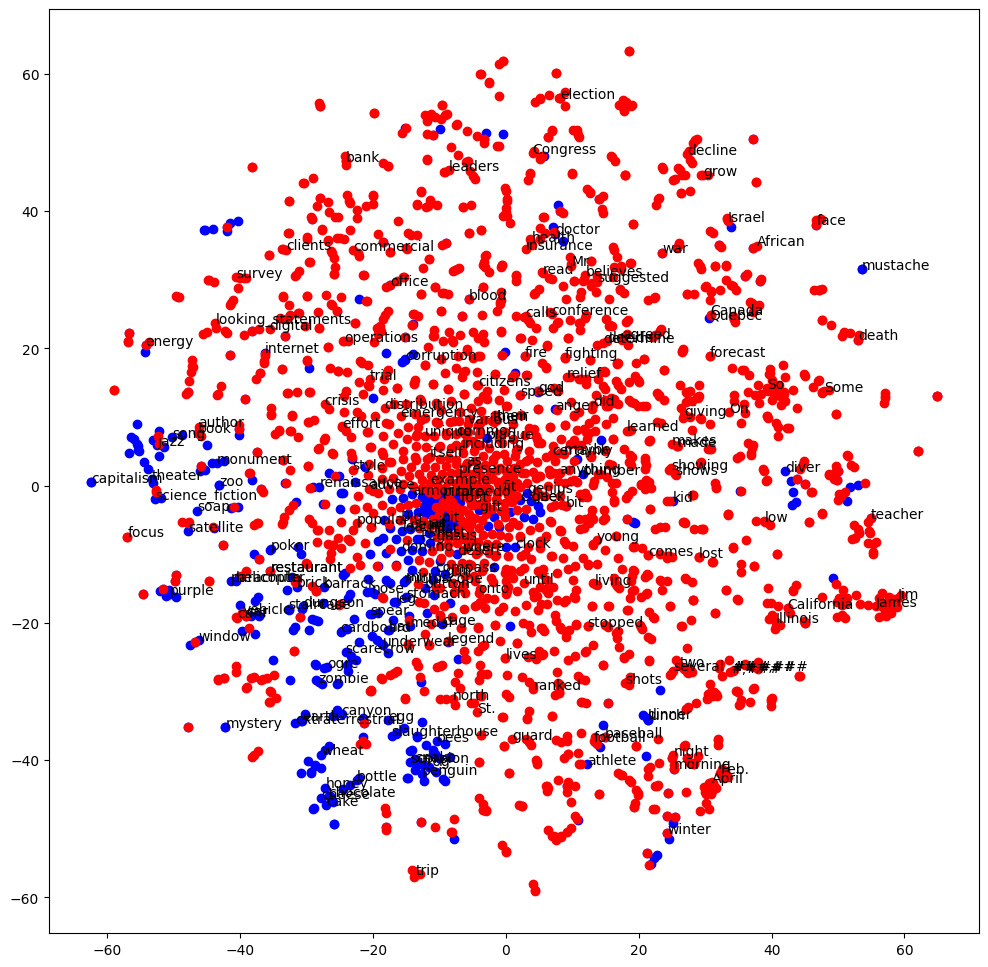

In [6]:
google_words = [word for word in google_news_wv.index_to_key[:2_000]]
google_vectors = np.asarray([google_news_wv[word] for word in google_words])

# reduce using t-SNE
tsne = TSNE(n_components=num_dimensions, random_state=0)
both_vectors = np.concatenate((official_vectors, google_vectors))
tsne_both_vectors = tsne.fit_transform(both_vectors)
x_vals, y_vals, *_ = zip(*tsne_both_vectors) # x has v[0] for each vector, y has v[1]
official_x_vals, official_y_vals = x_vals[:len(official_vectors)], y_vals[:len(official_vectors)]
google_x_vals, google_y_vals = x_vals[len(official_vectors):], y_vals[len(official_vectors):]

fig, ax = plt.subplots(figsize=(12, 12))
plot_with_matplotlib(fig, ax, official_x_vals, official_y_vals, official_words)
plot_with_matplotlib(fig, ax, google_x_vals, google_y_vals, google_words, color="r")

The words are actually a lot less clustered than I thought they would be.

The most striking thing is the sidedness; I think this corresponds to the prediction I made based off of the noun hypothesis, as evidenced by the lack of official words near verbs.

One interesting thing to notice is that a portion of words are separated from the official words by a large margin; perhaps such words could be used to highly throw off an opposing intercepter.

On the other hand, for official words that are outliers, using closely related words will leak a lot more information. Words like "hockey" seem a lot worse to get than "scarecrow" and "doll" because there are fewer similar official words to them.

Another interesting thing to notice is that the official words are actually less clustered than the most common words in the model; perhaps this asymmetry could be taken advantadge of? The main sources of clustering in the official words seem to be "animal" and "food" categories.